<a href="https://colab.research.google.com/github/jacr2006/tensorflow/blob/master/perceptron_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Perceptron

El propósito de este notebook es entrenar un Perceptrón (Red Neuronal de una capa) para un problema de clasificación multiclase de digitos escritos a mano. Finalmente se tratará de inferir la clase a la que pertenece una imagen de un digito escritos a mano. Para el entrenamiento usaremos el dataset MNIST conformado por 60.000 imagenes de entrenamiento y 10.000 imagenes de prueba.

Es posible usar un Perceptron para este problema porque de antemano sabemos que el conjunto de entranamiento el linealmente separable.
Este dataset esta disponible en la libreria "tensorflow_datasets" de tensorflow.

In [1]:
!pip install -q tensorflow tensorflow-datasets matplotlib

     |████████████████████████████████| 2.3MB 46.1MB/s 


Importar las librerias necesarias

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

W0901 19:26:10.879440 140616289519488 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



###Datos
En este dataset la data de entrada es un conjunto imagenes que estan centradas y estandarizadas en tamaño (28X28x1 pixels, en blanco y negro), no es requerida limpieza de los datos. La data de salida esta conformada por un conjuto finito de datos etiquetados entre el valor 0 y el 9, data categórica.
Lectura de los datos de entrenamiento

In [3]:
train_ds = tfds.load("mnist", split=tfds.Split.TRAIN, batch_size=-1)
numpy_ds = tfds.as_numpy(train_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

W0901 19:26:53.580692 140616289519488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0901 19:27:01.409023 140616289519488 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


W0901 19:27:02.393204 140616289519488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/dataset_builder.py:494: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [4]:
numpy_images.shape

(60000, 28, 28, 1)

Como la entrada al Perceptron debe ser de una dimension, se requiere una transformacion de la data de entrada de 60000x28x28x1 a 60000x784

In [0]:
width = 28 # ancho de la imagen en pixels
height = 28 # altura de la imagen en pixels
flat = width * height # numero de pixels de la imagen
class_output = 10 # numero de clases

In [0]:
numpy_images=numpy_images.reshape(60000,flat)

In [7]:
numpy_images.shape

(60000, 784)

La siguiente figura muestra la imagen de un numero perteneciente al conjunto de entrenamiento

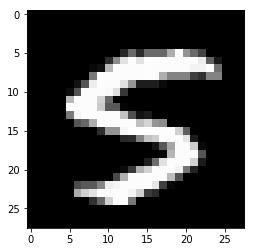

In [8]:
image_index = 42 
img=numpy_images[image_index].reshape(width,height)
plt.imshow(img, cmap="gray")

In [9]:
numpy_labels.shape

(60000,)

Lectura de los datos de prueba

In [0]:
test_ds = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
numpy_ds_test = tfds.as_numpy(test_ds)
numpy_images_test, numpy_labels_test = numpy_ds_test["image"], numpy_ds_test["label"]

In [11]:
numpy_images_test.shape

(10000, 28, 28, 1)

In [12]:
numpy_images_test=numpy_images_test.reshape(10000,flat)
numpy_images_test.shape

(10000, 784)

In [0]:
sess = tf.InteractiveSession()#se crea una sesion interativa, ideal para notebooks

Los algoritmos de "machine learning" no funcionan bien con data categorica directamente. Por tanto, se deben codificar estas categorias numéricas en vectores binarios. Para este caso donde existen 10 clases de salida representadas por un valor decimal entre 0 y 9. Se codificaran en un vector binario 1x10 donde solo existe una columna con un valor 1 mientras el resto son 0.

In [0]:
numpy_labels=tf.one_hot(numpy_labels, depth=class_output)
labels=sess.run(numpy_labels)

In [15]:
labels.shape

(60000, 10)

Se realiza la misma codificación para el conjunto de prueba

In [0]:
numpy_labels_test=tf.one_hot(numpy_labels_test, depth=class_output)
labels_test=sess.run(numpy_labels_test)

In [17]:
labels_test.shape

(10000, 10)

###Entrenamiento
Se crean "placeHolders" para la variables de entrada (x) y la de salida (y_).

In [0]:
x  = tf.placeholder(tf.float32, shape=[None, flat])
y_ = tf.placeholder(tf.float32, shape=[None, class_output])

Se crean las variables del modelo del perceptron y = x * W + b, donde (x) son las imagenes y (y) las etiquetas. W y b son los pesos y bias del modelo respectivamente

In [0]:
W = tf.Variable(tf.zeros([flat, class_output],tf.float32))
b = tf.Variable(tf.zeros([class_output],tf.float32))

In [0]:
sess.run(tf.global_variables_initializer())

Por definicion el Perceptron utiliza como función de activación "softmax"

In [0]:
y = tf.nn.softmax(tf.add(tf.matmul(x,W), b))

In [0]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

Para este caso, se usa Gradiente Descendente como algoritmo de optimización

In [0]:
learning_rate=0.00001#se selecciona un "learning rate" pequeño, y se observa la convergencia
optimizer=tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

Se ejecutan un conjunto finito de iteraciones, y se analiza la convergencia mediendo la diferencia entre dos sucesivos valores de costo

In [24]:
cost=0
for i in range(1000):
    step, new_cross_entropy, new_W, new_b = sess.run([train_step, cross_entropy, W, b], feed_dict={x: numpy_images, y_: labels})
    diff=abs(cost-new_cross_entropy)
    cost=new_cross_entropy
    print("Paso: {}, Costo: {}".format(i, new_cross_entropy) )
    if i > 1 and diff < .0001:#usamos un criterio de convergencia de 10-3 para finalizar el entrenamiento
      print("El entrenamiento converge")
      break
    

Paso: 0, Costo: 2.3025853633880615
Paso: 1, Costo: 1.7197861671447754
Paso: 2, Costo: 1.38747239112854
Paso: 3, Costo: 1.1929572820663452
Paso: 4, Costo: 1.0867971181869507
Paso: 5, Costo: 0.9944651126861572
Paso: 6, Costo: 0.9694867134094238
Paso: 7, Costo: 0.8473393321037292
Paso: 8, Costo: 0.8233635425567627
Paso: 9, Costo: 0.7672826051712036
Paso: 10, Costo: 0.752696692943573
Paso: 11, Costo: 0.7033041715621948
Paso: 12, Costo: 0.6863644123077393
Paso: 13, Costo: 0.65372234582901
Paso: 14, Costo: 0.6370963454246521
Paso: 15, Costo: 0.6150473952293396
Paso: 16, Costo: 0.6004779934883118
Paso: 17, Costo: 0.5851417183876038
Paso: 18, Costo: 0.5731908679008484
Paso: 19, Costo: 0.5619329214096069
Paso: 20, Costo: 0.5523132681846619
Paso: 21, Costo: 0.5435487627983093
Paso: 22, Costo: 0.5357035398483276
Paso: 23, Costo: 0.5285320281982422
Paso: 24, Costo: 0.5219516158103943
Paso: 25, Costo: 0.515857458114624
Paso: 26, Costo: 0.5101805925369263
Paso: 27, Costo: 0.5048637390136719
Paso: 28

Se determina la precision del modelo con los datos del conjunto de prueba

In [25]:
prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))*100
resul=tf.print("La precision del modelo es:", accuracy)
resul=sess.run(resul, feed_dict={x: numpy_images_test, y_: labels_test} )

La precision del modelo es: 91.61


###Inferencia
Con los parametros del modelo ya obtenidos (ultimos W y b), se selecciona una imagen aleatoria del conjunto de prueba y se hace pasar a traves del modelo

El valor inferido es: [6]


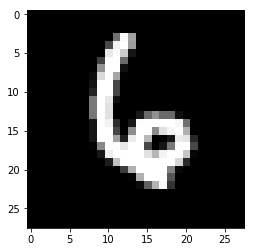

In [26]:
image_index = 5672
img=numpy_images_test[image_index].reshape(width,height)
plt.imshow(img, cmap="gray")

prediction=tf.nn.softmax( tf.add( tf.matmul( tf.cast(tf.expand_dims( numpy_images_test[image_index],0), tf.float32), tf.cast(new_W, tf.float32) ), new_b ) )
encode=tf.argmax(prediction, axis=1)#la predicion obtenida es un vector binario, se debe codificar a un valor numérico
res=tf.print("El valor inferido es:", encode)
sess.run(res)

In [0]:
sess.close() 